In [80]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np
from hessians_calc import *
from demo_parity_calc import *
import copy


In [81]:
cols = ['status', 'duration', 'credit_hist', 'purpose', 'credit_amt', 'savings', 'employment', 'installment_rate', 'personal_status', 'debtors', 'residencesince', 'property', 'age', 'install_plans', 'housing', 'existing_credits', 'job', 'maintenance_paying_people', 'telephone', 'foreign_worker', 'result']
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
df = pd.read_csv(url, delimiter=' ', names=cols, index_col=False)
df['result'] = df['result'].replace(2,0)

In [82]:
df.head()

,status,duration,credit_hist,purpose,credit_amt,savings,employment,installment_rate,personal_status,debtors,...,property,age,install_plans,housing,existing_credits,job,maintenance_paying_people,telephone,foreign_worker,result
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0


In [83]:
def preprocess_german(df):
    df['status'] = df['status'].map({'A11': 0, 'A12': 1, 'A13': 2, 'A14': 3}).astype(int)
    df['credit_hist'] = df['credit_hist'].map({'A34': 0, 'A33': 1, 'A32': 2, 'A31': 3, 'A30': 4}).astype(int)
    df.loc[(df['credit_amt'] <= 2000), 'credit_amt'] = 0
    df.loc[(df['credit_amt'] > 2000) & (df['credit_amt'] <= 5000), 'credit_amt'] = 1
    df.loc[(df['credit_amt'] > 5000), 'credit_amt'] = 2
    df.loc[(df['duration'] <= 12), 'duration'] = 0
    df.loc[(df['duration'] > 12) & (df['duration'] <= 24), 'duration'] = 1
    df.loc[(df['duration'] > 24) & (df['duration'] <= 36), 'duration'] = 2
    df.loc[(df['duration'] > 36), 'duration'] = 3
    df['age'] = df['age'].apply(lambda x : 1 if x >= 45 else 0) # 1 if old, 0 if young
    df['savings'] = df['savings'].map({'A61': 0, 'A62': 1, 'A63': 2, 'A64': 3, 'A65': 4}).astype(int)
    df['employment'] = df['employment'].map({'A71': 0, 'A72': 1, 'A73': 2, 'A74': 3, 'A75': 4}).astype(int)
    df['gender'] = df['personal_status'].map({'A91': 1, 'A92': 0, 'A93': 1, 'A94': 1, 'A95': 0}).astype(int)
    df['debtors'] = df['debtors'].map({'A101': 0, 'A102': 1, 'A103': 2}).astype(int)
    df['property'] = df['property'].map({'A121': 3, 'A122': 2, 'A123': 1, 'A124': 0}).astype(int)
    df['install_plans'] = df['install_plans'].map({'A141': 1, 'A142': 1, 'A143': 0}).astype(int)
    df['job'] = df['job'].map({'A171': 0, 'A172': 1, 'A173': 2, 'A174': 3}).astype(int)
    df['telephone'] = df['telephone'].map({'A191': 0, 'A192': 1}).astype(int)
    df['foreign_worker'] = df['foreign_worker'].map({'A201': 1, 'A202': 0}).astype(int)
    pd.get_dummies(df, columns=['purpose', 'housing'], drop_first=True)

    return df

In [84]:
df = preprocess_german(df)

In [85]:
df = df.drop(["purpose", "housing", "personal_status"], axis=1)
x = df[['status', 'duration', 'credit_hist', 'credit_amt', 'savings',
       'employment', 'installment_rate', 'debtors', 'residencesince',
       'property', 'age', 'install_plans', 'existing_credits', 'job',
       'maintenance_paying_people', 'telephone', 'foreign_worker',
       'gender']]

y = df['result']

In [86]:
len(y)

1000

In [87]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [88]:
x_test_orig = copy.deepcopy(x_test)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test_scalar = sc.fit_transform(x_test)
print(type(x_test_scalar))
print(type(x_test))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [89]:
#calculate the influence of each train data point by retraining
clf_name = 'LogisticRegression'

In [90]:
def demographic_parity(x_train_temp, y_train_temp, x_test_temp):
    # find the predictive probabilities for the protected and privileged groups based on 'age'
    sc = StandardScaler()
    x_test_scalar_temp = sc.fit_transform(x_test_temp)
    # logistic_model = LogisticRegression(input_size=x_train_temp.shape[1], epoch_num=1000)
    clf = eval(clf_name)(input_size=x_train_temp.shape[-1])
    clf.fit(x_train_temp, y_train_temp)

    y_pred_proba_temp = clf.predict_proba(x_test_scalar_temp)
    # print(y_pred_proba_temp.shape)
    # print(y_pred_proba_temp[0:10])

    privileged_gp_indices = x_test_temp[x_test_temp['age'] == 1].index
    protected_gp_indices = x_test_temp[x_test_temp['age'] == 0].index
    # y_pred_proba returns an array, how do we know whether that is for the positive label or negative label.
    # assuming it gives us the probability of the positive class

    privileged_positive_pred = 0
    for x in range(len(privileged_gp_indices)):
        privileged_positive_pred += y_pred_proba_temp[privileged_gp_indices[x]]
    privileged_positive_pred /= len(privileged_gp_indices)

    protected_positive_pred = 0
    for x in range(len(protected_gp_indices)):
        protected_positive_pred += y_pred_proba_temp[protected_gp_indices[x]]
    protected_positive_pred /= len(protected_gp_indices)

    # privileged_positive_pred = y_pred_proba[privileged_gp_indices, 1][y_pred_proba[privileged_gp_indices, 1] > 0.5].mean()
    # protected_positive_pred = y_pred_proba[protected_gp_indices, 1][y_pred_proba[protected_gp_indices, 1] > 0.5].mean()
    # print(protected_positive_pred - privileged_positive_pred)

    return  protected_positive_pred - privileged_positive_pred

In [91]:
import pickle 

data = {'Xtrain': x_train, 'Ytrain': y_train, 'Xtest': x_test}
with open('data.pkl', 'wb') as f:
    pickle.dump(data,f)

In [92]:
dp_ori = demographic_parity(x_train, y_train, x_test)
print(dp_ori)


-0.07884407313540576


In [93]:
# find the influence of each data point in X-train by retraining the model, now we have the actual dp and we need fined the delta for different points for demo parity
# results are calculated and stored in a file, hence commented to save the train time for 800 iterations 

x_train_a = np.copy(x_train)
y_train_a = np.copy(y_train)

result = []

for i in range(len(x_train)):
    x_train_new = np.append(x_train_a, [x_train[i]], axis=0)
    y_train_new = np.append(y_train_a, [y_train[i]])
    res = dp_ori - demographic_parity(x_train_new, y_train_new, x_test)
    print(res)
    result.append(res)

# print(result)


-4.6404823660806116e-05
0.0006270801648498026
0.0002113727852702807
-0.0009117088280617969
0.0005546328611671925
-0.00011341273784637451
-0.00014510564506053925
-0.00030114660039537444
-0.001036658231168941
0.0006599892862141354
-0.0002996058203280638
7.513910532663814e-07
-0.001447703875601336
-0.0008579991757869943
0.0009602634236216545
0.0008888709358870761
0.0004865717142820136
0.001055893208831593
-0.0010463623329997063
-6.070770323274299e-05
-0.000644022319465809
-0.0005790234543383566
0.0003433018922806008
-0.00045615239068863556
-0.0002035520039498362
0.0009939458221196462
-0.0004223829135299173
0.0008645267225801945
-0.0014827479608356953
-0.0004303567111492157
6.0589984059999935e-06
-0.0004762241616844687
-0.00028879744932053253
0.001496396772563524
-0.0003900079056620154
-0.00010188017040491104
-0.00029058214277022376
0.001168322097510166
0.00036748340353376374
-0.00036016618832945824
0.00039448123425245285
2.6125647127561713e-05
0.0012458271346985628
0.0009003139100969282
1

In [94]:
clf = eval('LogisticRegression')(input_size=x_train.shape[-1])
if isinstance(clf, LogisticRegression):
    loss_func = logistic_loss_torch


In [95]:
del_F_del_theta = del_spd_del_theta(clf, x_test_orig, x_test_scalar, y_test)
print(del_F_del_theta.shape)
print(type(del_F_del_theta))

(19,)
<class 'numpy.ndarray'>


In [96]:
hessian_all_points = get_hessian_all_points(clf, x_train, y_train, loss_func)


100%|██████████| 800/800 [00:05<00:00, 145.08it/s]


In [97]:
print(hessian_all_points.shape)

(800, 19, 19)


In [98]:
del_L_del_theta = get_del_L_del_theta(clf, x_train, y_train, loss_func)
print(type(del_L_del_theta))
print(del_L_del_theta.shape)

<class 'numpy.ndarray'>
(800, 19)


In [99]:
hinv_v, hinv = get_hinv_v(hessian_all_points, del_F_del_theta) 


In [100]:
print(hinv_v.shape)

(19,)


df/d_epsi = df/d_theta * d_theta/d_epsi

d_theta/d_epsi = (1/n)* -H_inv * dL/d_theta 

df/d_theta = del_F_del_theta

In [101]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta))  #it should be hessian* dL/d_theta 
# and then it should be multiplied by df/d_theta

In [102]:
#influence for each data point 
inf = np.matmul(np.transpose(hinv_v), del_F_del_theta)
inf = inf * 0.00125
print(inf.shape)

(800,)


In [103]:
print(type(inf))

print(np.min(inf))
print(np.max(inf))


<class 'numpy.ndarray'>
-0.003522188608237935
0.005162322711265936


In [104]:
print(inf)

[-3.96541692e-04  3.29059097e-03  1.61011412e-04 -1.22017823e-03
  5.53912021e-04 -4.75858672e-04 -4.45956845e-04 -7.76777226e-04
 -2.04562861e-03  7.00860846e-04 -8.50432266e-04 -1.17523167e-04
 -1.68265350e-03 -7.48167324e-04  1.86981361e-03  8.06399836e-04
  4.47141477e-04  2.32661241e-03 -1.59325294e-03  1.46984578e-04
 -4.79455126e-04 -6.99653175e-04  7.02935826e-04 -1.11073475e-03
  2.35447339e-05  9.99647760e-04 -5.28378294e-04  8.49050374e-04
 -1.78102784e-03 -4.85535094e-04 -3.63700168e-04 -1.17500732e-03
 -9.97570539e-04  1.42905642e-03 -4.31504869e-04  2.32624841e-05
 -3.49407585e-04  3.44993698e-03  2.51651752e-04 -5.84815857e-04
  6.34775336e-04 -3.48251435e-05  1.30440533e-03  9.05350855e-04
  2.41552702e-05 -9.44416904e-04 -1.29654420e-03  7.32802115e-04
 -5.66681647e-04 -4.70776016e-04 -3.96546968e-04 -3.62987777e-04
 -1.58156282e-03 -1.00249943e-03 -1.03622730e-03 -8.18897169e-04
 -4.30373269e-04  1.15526725e-03 -1.69663664e-03 -2.82810879e-04
 -8.02325166e-04 -1.21011

In [105]:
# import matplotlib.pyplot as plt
# df = pd.DataFrame({'Trained': result, 'Calculated': inf})
# plt.plot(df['Trained'], df['Calculated'], marker='o', linestyle='-')
# plt.title('Graph between Trained and Calculated')
# plt.xlabel('Trained diff in dp for each data point')
# plt.ylabel('Calculated diff in dp for each data point')
# plt.grid(True)
# plt.show()

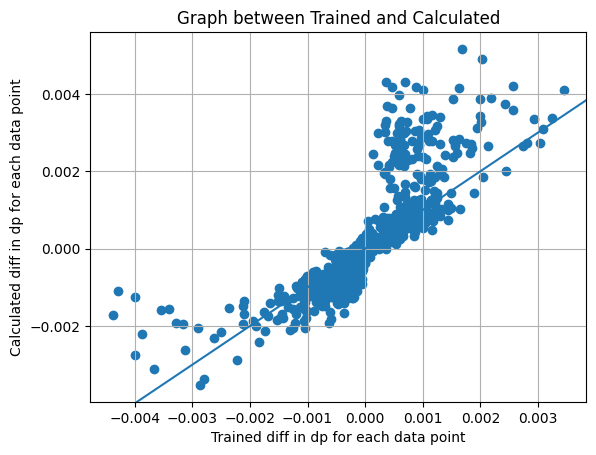

In [106]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df = pd.DataFrame({'Trained': result, 'Calculated': inf})
ax.scatter(df['Trained'], df['Calculated'], marker='o')
plt.title('Graph between Trained and Calculated')
plt.xlabel('Trained diff in dp for each data point')
plt.ylabel('Calculated diff in dp for each data point')
plt.grid(True)

ax.axline((0, 0), slope=1)
plt.show()
